# PoseNet for Self-Localization on Apolloscape Dataset

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter
from utils.common import calc_poses_params

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline
plt.ion()


## Load Apolloscape Dataset

In [2]:
APOLLO_PATH = "./data/apolloscape"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor(),
    normalize
])


train_record = 'Record001'
train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=train_record, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True)

val_record = 'Record011'
val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)

test_record = 'Record013'
test_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=test_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)



print(train_dataset)
print(val_dataset)
print(test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=8) # batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=8) # batch_size = 75
test_dataloader = DataLoader(test_dataset, batch_size=8) # batch_size = 75


Dataset: Apolloscape
    Road: zpark-sample
    Record: Record001
    Train: True
    Normalize Poses: True
    Length: 121 of 1121
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record011
    Train: False
    Normalize Poses: True
    Length: 87 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record013
    Train: False
    Normalize Poses: True
    Length: 120 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Reco

## Draw Train and Val datasets

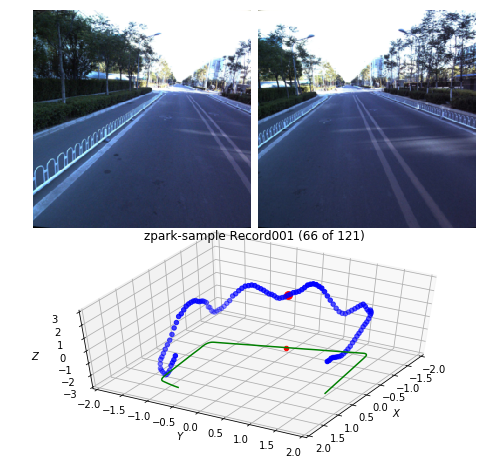

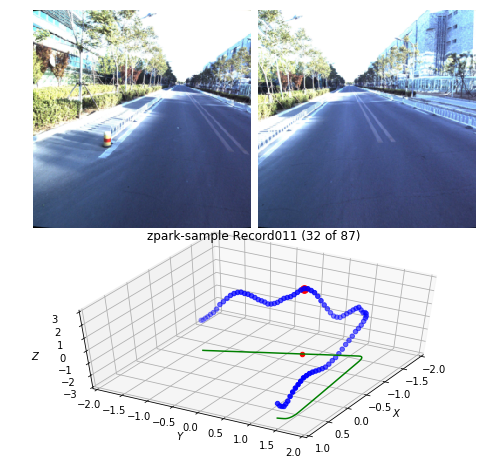

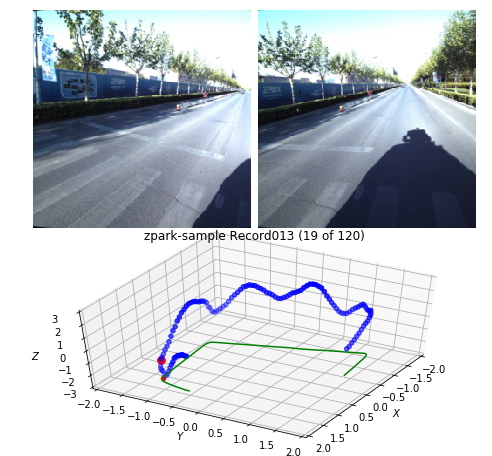

In [3]:
# Draw datasets
draw_record(train_dataset)
plt.show()

draw_record(val_dataset)
plt.show()

draw_record(test_dataset)
plt.show()

## Device set up

In [4]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cpu


## Train and Validate Functions

In [5]:
# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True):
    
    # switch model to training
    model.train()
    
#     log_freq = 0
    
    losses = AverageMeter()
    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
#         if idx < len(train_loader) - 1: continue
        data_time = (time.time() - end)
        
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        
        losses.update(loss, len(batch_images) * batch_images[0].size(0))
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
    if print_sum:
        print('Epoch: [{}/{}]\tTraining Loss: {:.3f}'.format(epoch, max_epoch - 1, losses.avg))
        
    return losses.avg
    
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
#     log_freq = 0 # len(val_loader)
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss, len(batch_images) * batch_images[0].size(0))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))
                
    
    if print_sum:
        print('Epoch: [{}]\tValidation Loss: {:.3f}'.format(epoch, losses.avg))
        
    return losses.avg


## Create Model, Criterion and Optimizer

In [7]:
# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Create model
model = PoseNet(feature_extractor)
model = model.to(device)

# Criterion
criterion = PoseNetCriterion()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

start_epoch = 0


## Restore from Chekpoint

In [8]:
# Restore from checkpoint
checkpoint_file = '_checkpoints/20180804_084337_apollo_zpark_r001_v2_e008.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']


## Run Training

In [10]:
if 'start_epoch' not in locals():
    start_epoch = 0
    
# train_dataloader = DataLoader(train_dataset, batch_size=8) # batch_size = 75
# optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.0005)

n_epochs = start_epoch + 1
print('Training ...')
val_freq = 5
for e in range(start_epoch, n_epochs):

    end = time.time()
    train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=1)
#     print('Train epoch time: {:.3f}'.format(time.time() - end))
    
#     print('Validation ...')
    if e & val_freq == 0:
        end = time.time()
        validate(val_dataloader, model, criterion, e, log_freq=1)
#     print('Validation epoch time: {:.3f}'.format(time.time() - end))

#     print('Test dataset ...')
#     validate(test_dataloader, model, criterion, e, log_freq=0)

start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))


Training ...
Epoch: [2/7]	Batch: [0/15]	Time: 7.299	Data Time: 0.297	Loss: 4.136	Avg Loss: 4.136	
Epoch: [2/7]	Batch: [1/15]	Time: 6.310	Data Time: 0.280	Loss: 4.342	Avg Loss: 4.239	
Epoch: [2/7]	Batch: [2/15]	Time: 6.244	Data Time: 0.259	Loss: 2.643	Avg Loss: 3.707	
Epoch: [2/7]	Batch: [3/15]	Time: 6.707	Data Time: 0.263	Loss: 2.253	Avg Loss: 3.343	
Epoch: [2/7]	Batch: [4/15]	Time: 6.252	Data Time: 0.276	Loss: 1.543	Avg Loss: 2.983	
Epoch: [2/7]	Batch: [5/15]	Time: 6.284	Data Time: 0.264	Loss: 1.351	Avg Loss: 2.711	
Epoch: [2/7]	Batch: [6/15]	Time: 7.401	Data Time: 0.259	Loss: 1.842	Avg Loss: 2.587	
Epoch: [2/7]	Batch: [7/15]	Time: 9.119	Data Time: 0.324	Loss: 1.419	Avg Loss: 2.441	
Epoch: [2/7]	Batch: [8/15]	Time: 7.034	Data Time: 0.274	Loss: 1.485	Avg Loss: 2.335	
Epoch: [2/7]	Batch: [9/15]	Time: 6.713	Data Time: 0.388	Loss: 2.193	Avg Loss: 2.321	
Epoch: [2/7]	Batch: [10/15]	Time: 6.352	Data Time: 0.282	Loss: 1.570	Avg Loss: 2.253	
Epoch: [2/7]	Batch: [11/15]	Time: 7.209	Data Time: 

Epoch: [7/7]	Batch: [5/15]	Time: 6.549	Data Time: 0.232	Loss: 1.048	Avg Loss: 2.289	
Epoch: [7/7]	Batch: [6/15]	Time: 6.410	Data Time: 0.236	Loss: 1.264	Avg Loss: 2.143	
Epoch: [7/7]	Batch: [7/15]	Time: 6.510	Data Time: 0.247	Loss: 1.113	Avg Loss: 2.014	
Epoch: [7/7]	Batch: [8/15]	Time: 6.601	Data Time: 0.236	Loss: 1.132	Avg Loss: 1.916	
Epoch: [7/7]	Batch: [9/15]	Time: 6.780	Data Time: 0.271	Loss: 1.787	Avg Loss: 1.903	
Epoch: [7/7]	Batch: [10/15]	Time: 8.199	Data Time: 0.243	Loss: 1.195	Avg Loss: 1.839	
Epoch: [7/7]	Batch: [11/15]	Time: 8.470	Data Time: 0.269	Loss: 1.573	Avg Loss: 1.817	
Epoch: [7/7]	Batch: [12/15]	Time: 7.381	Data Time: 0.272	Loss: 1.755	Avg Loss: 1.812	
Epoch: [7/7]	Batch: [13/15]	Time: 8.641	Data Time: 0.266	Loss: 1.493	Avg Loss: 1.789	
Epoch: [7/7]	Batch: [14/15]	Time: 7.397	Data Time: 0.254	Loss: 1.813	Avg Loss: 1.791	
Epoch: [7/7]	Batch: [15/15]	Time: 1.143	Data Time: 0.052	Loss: 1.716	Avg Loss: 1.790	
Epoch: [7/7]	Training Loss: 1.790
n_epochs = 8


In [69]:
def quaternion_angular_error(q1, q2):
    """
    angular error between two quaternions
    :param q1: (4, )
    :param q2: (4, )
    :return:
    """
    d = abs(np.dot(q1, q2))
    abs_q1 = np.linalg.norm(q1)
    abs_q2 = np.linalg.norm(q2)
    d = d / (abs_q1 * abs_q2)
    d = min(1.0, max(-1.0, d))
    theta = 2 * np.arccos(d) * 180 / np.pi
    return theta


poses_mean = val_dataset.poses_mean
poses_std = val_dataset.poses_std


model.eval()

gt_poses = np.empty((0, 7))
pred_poses = np.empty((0, 7))

for idx, (batch_images, batch_poses) in enumerate(val_dataloader):
    batch_images = [x.to(device) for x in batch_images]
    batch_poses = [x.to(device) for x in batch_poses]

    out = model(batch_images)
    loss = criterion(out, batch_poses)
    
    # move data to cpu & numpy
    batch_poses = [x.detach().cpu().numpy() for x in batch_poses]
    out = [x.detach().cpu().numpy() for x in out]
    
    gt_poses = np.vstack((gt_poses, *batch_poses))
    pred_poses = np.vstack((pred_poses, *out))
    
    print('{}/{}: loss = {}'.format(idx, len(val_dataloader) - 1, loss))
#     if idx == 1:
#         break

print('=======================================')
print('=======================================')

# un-normalize translation
gt_poses[:, :3] = gt_poses[:, :3] * poses_std + poses_mean
pred_poses[:, :3] = pred_poses[:, :3] * poses_std + poses_mean

print('gt_poses = {}'.format(gt_poses.shape))
print('pred_poses = {}'.format(pred_poses.shape))

t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))


# calc losses
# t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
# q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

#
# print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
# print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
# print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))


print('=======================================')
print('=======================================')



0/11: loss = 1.3867952823638916
1/11: loss = 1.6618338823318481
2/11: loss = 1.0397894382476807
3/11: loss = 1.3223247528076172
4/11: loss = 1.5550674200057983
5/11: loss = 1.0035110712051392
6/11: loss = 1.5906435251235962
7/11: loss = 1.291161298751831
8/11: loss = 1.8242428302764893
9/11: loss = 2.541210889816284
10/11: loss = 4.631916522979736
gt_poses = (174, 7)
pred_poses = (174, 7)


In [70]:
pred_normal = np.hstack((np.random.normal(poses_mean, poses_std, (gt_poses.shape[0], 3)), pred_poses[:, 3:]))

t_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_poses[:, :3], gt_poses[:, :3])])
q_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_poses[:, 3:], gt_poses[:, 3:])])

t1_loss = np.asarray([np.linalg.norm(p - t) for p, t in zip(pred_normal[:, :3], gt_poses[:, :3])])
q1_loss = np.asarray([quaternion_angular_error(p, t) for p, t in zip(pred_normal[:, 3:], gt_poses[:, 3:])])

# print(t_loss)
# print(q_loss)
print('poses_std = {:.3f}'.format(np.linalg.norm(poses_std)))
print('T: median = {:.3f}, mean = {:.3f}'.format(np.median(t_loss), np.mean(t_loss)))
print('R: median = {:.3f}, mean = {:.3f}'.format(np.median(q_loss), np.mean(q_loss)))

print('T1: median = {:.3f}, mean = {:.3f}'.format(np.median(t1_loss), np.mean(t1_loss)))
print('R1: median = {:.3f}, mean = {:.3f}'.format(np.median(q1_loss), np.mean(q1_loss)))

# print(pred_poses[1, 3:])
# print(gt_poses[1, 3:])
# print(quaternion_angular_error(pred_poses[1, 3:], gt_poses[1, 3:]))

poses_std = 280.970
T: median = 228.847, mean = 235.337
R: median = 27.846, mean = 43.165
T1: median = 324.367, mean = 351.484
R1: median = 27.846, mean = 43.165


In [64]:
# normal pred
# print('poses_mean = {}'.format(poses_mean))
# print('poses_std = {}'.format(poses_std))
# pred_normal = np.hstack((np.random.normal(poses_mean, poses_std, (gt_poses.shape[0], 3)), pred_poses[:, 3:]))
# print(pred_normal)


poses_mean = [  449.95782055 -2251.24771214    40.17147932]
poses_std = [123.39589457 252.42350964   0.28021513]
[[ 6.88739051e+02 -2.29170002e+03  4.02802151e+01  6.07545197e-01
  -6.99017763e-01 -2.45954543e-01  2.79129952e-01]
 [ 5.22526363e+02 -2.13530672e+03  4.01022695e+01  6.09859645e-01
  -7.36070156e-01 -2.50439733e-01  2.85084695e-01]
 [ 5.41389377e+02 -2.13456275e+03  4.06429228e+01  6.23020470e-01
  -7.08156705e-01 -4.85539436e-03 -4.27280813e-02]
 [ 2.35650528e+02 -2.40309997e+03  4.05154303e+01  6.23686492e-01
  -6.42602861e-01 -2.01792061e-01  2.16117706e-02]
 [ 4.14154150e+02 -1.97166838e+03  3.99305240e+01  6.63640320e-01
  -7.38261938e-01 -1.37847021e-01 -1.77954420e-01]
 [ 2.48224412e+02 -2.09830014e+03  4.00163617e+01  6.38427496e-01
  -7.44608521e-01 -1.30718559e-01 -1.38506502e-01]
 [ 6.81995351e+02 -2.45800068e+03  4.04970977e+01  6.28130734e-01
  -6.67378366e-01 -1.45571262e-01 -1.76759157e-02]
 [ 3.87826500e+02 -2.29082448e+03  3.96784452e+01  5.60268104e-01
  

## Test Model

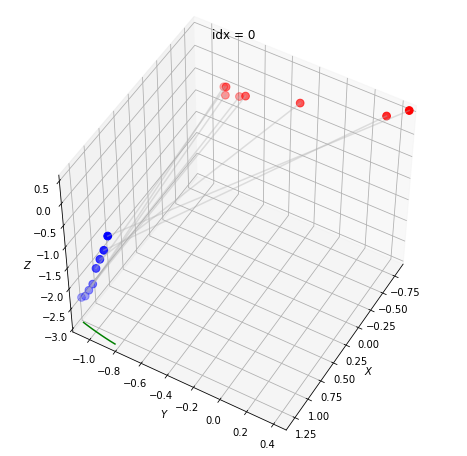

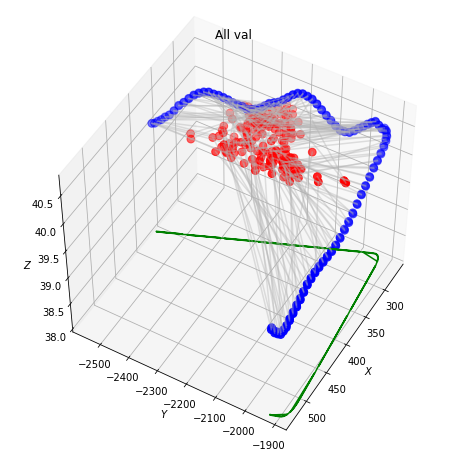

In [73]:
# Test model
# tb_images, tb_poses = next(iter(test_dataloader))
# print('tb_poses = {}'.format(tb_poses))


def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(int(p_min[2] - 1), p_max[2])
    return p_min, p_max, p_mean, p_std


def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=True, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()


    

# train_dataloader = DataLoader(train_dataset, batch_size=16)

# p_min, p_max, p_mean, p_std = train_dataset.get_poses_params(all_records=False)


# fig = plt.figure(figsize=(8, 8))
# ax = plt.axes(projection='3d')

# ax.set_xlabel('$X$')
# ax.set_ylabel('$Y$')
# ax.set_zlabel('$Z$')
# ax.view_init(50, 30)


# ax.set_xlim(int(p_min[0] - 1), int(p_max[0] + 1))
# ax.set_ylim(int(p_min[1] - 1), int(p_max[1] + 1))
# ax.set_zlim(int(p_min[2] - 1), int(p_max[2] + 1))

model.eval()

for idx, (tb_images, tb_poses) in enumerate(train_dataloader):
    tb_images = [x.to(device) for x in tb_images]
    output = model(tb_images)
#     print('output = {}'.format(output))

    # detach
    output = [x.cpu().detach().numpy() for x in output]
    
    draw_pred_gt_poses(output[0], tb_poses[0])
    plt.title('idx = {}'.format(idx))
    plt.show()
    
    # gt + pred poses
#     all_poses = np.concatenate((output[0][:, :3], tb_poses[0][:, :3]))
#     set_3d_axes_limits(ax, all_poses, pose_format=train_dataset.pose_format)
    
#     draw_poses(ax, output[0][:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
#     draw_poses(ax, tb_poses[0][:, :3], proj=True, proj_z=int(p_min[2] - 1), c='b', s=60)
#     for i in range(output[0].shape[0]):
#         pp = output[0][i, :3]
#         gp = tb_poses[0][i, :3]
#         pps = np.vstack((pp, gp))
#         ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
    
    if idx == 0:
        break
        
#     plt.draw()
    
    
#     ax.scatter(tb_poses[0][:, 0], tb_poses[0][:, 1], tb_poses[0][:, 2], c='r')

plt.show()

draw_pred_gt_poses(pred_poses, gt_poses)
plt.title('All val')
plt.show()

## Save Model Checkpoint

In [11]:
# Save checkpoint
save_checkpoint(model, optimizer, 'apollo_zpark_r001_v2', n_epochs)
    

'_checkpoints/20180804_084337_apollo_zpark_r001_v2_e008.pth.tar'